In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load Indian Pines dataset
data_mat = sio.loadmat('/content/Indian_pines_corrected.mat')
gt_mat = sio.loadmat('/content/Indian_pines_gt.mat')

X = data_mat['indian_pines_corrected']  # Shape: (145, 145, 200)
y = gt_mat['indian_pines_gt']  # Shape: (145, 145)

print("Original Data Shape:", X.shape)
print("Ground Truth Shape:", y.shape)

# Reshape for PCA: (samples, bands)
X_reshaped = X.reshape(-1, X.shape[2])  # (145*145, 200)

# Apply PCA
pca = PCA(n_components=50, whiten=True)
X_pca = pca.fit_transform(X_reshaped)

# Normalize data
scaler = MinMaxScaler()
X_pca = scaler.fit_transform(X_pca)

# Reshape back to (145, 145, 50)
X_pca = X_pca.reshape(145, 145, 50)

print("PCA Reduced Data Shape:", X_pca.shape)


Original Data Shape: (145, 145, 200)
Ground Truth Shape: (145, 145)
PCA Reduced Data Shape: (145, 145, 50)


In [2]:
def create_3d_patches(X, y, patch_size=7):
    half_size = patch_size // 2
    padded_X = np.pad(X, ((half_size, half_size), (half_size, half_size), (0, 0)), mode='constant')

    X_patches, y_patches = [], []
    for i in range(half_size, X.shape[0] + half_size):
        for j in range(half_size, X.shape[1] + half_size):
            patch = padded_X[i - half_size:i + half_size + 1, j - half_size:j + half_size + 1, :]
            X_patches.append(patch)
            y_patches.append(y[i - half_size, j - half_size])

    return np.array(X_patches), np.array(y_patches)

# Create patches
X_patches, y_patches = create_3d_patches(X_pca, y)

# Reshape patches for 3D-CNN
X_patches = X_patches.reshape(-1, 7, 7, 50, 1)
print("Patch Data Shape:", X_patches.shape)


Patch Data Shape: (21025, 7, 7, 50, 1)


In [3]:
print(X_patches.shape)  # Check if it's 4D or 5D
print(X_patches.dtype)  # Should be float32 for augmentations

(21025, 7, 7, 50, 1)
float64


In [ ]:
import tensorflow as tf

def augment(x):
    # x = tf.cast(x, tf.float32)  # Ensure float32
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return x

X_patches_aug = tf.map_fn(augment, X_patches)


In [ ]:
def create_encoder(input_shape=(7, 7, 50, 1)):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
    x = layers.Dropout(0.3)(x)  # Prevent Overfitting

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation=None)(x)  # Projection Head

    model = keras.Model(inputs, x, name="SimCLR_Encoder")
    return model

encoder = create_encoder()
encoder.summary()


Model: "SimCLR_Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 7, 7, 50, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 7, 7, 50, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 50, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 4, 4, 25, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 4, 4, 25, 64)   │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 25, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 2, 2, 13, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 13, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3328)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │       426,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491,008 (1.87 MB)

 Trainable params: 490,816 (1.87 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
import tensorflow as tf

def contrastive_loss(z_i, z_j, temperature=0.5):
    # Normalize embeddings
    z_i = tf.math.l2_normalize(tf.reshape(z_i, [tf.shape(z_i)[0], -1]), axis=1)
    z_j = tf.math.l2_normalize(tf.reshape(z_j, [tf.shape(z_j)[0], -1]), axis=1)

    # Concatenate for all 2N samples
    z = tf.concat([z_i, z_j], axis=0)
    similarity_matrix = tf.matmul(z, z, transpose_b=True)  # [2N, 2N]

    # Scale by temperature
    logits = similarity_matrix / temperature

    # Labels: positive for each i is i + N
    batch_size = tf.shape(z_i)[0]
    labels = tf.range(batch_size)
    labels = tf.concat([labels + batch_size, labels], axis=0)

    # Mask to ignore similarity with self
    mask = tf.eye(2 * batch_size)
    logits_masked = logits * (1 - mask) - 1e9 * mask  # mask diagonal for numerical stability

    # Softmax cross entropy
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits_masked)
    return tf.reduce_mean(loss)


In [ ]:
contrastive_model = keras.Model(inputs=encoder.input, outputs=encoder.output)
contrastive_model.compile(optimizer='adam', loss=lambda y_true, y_pred: contrastive_loss(y_pred, y_pred))

# Ensure Model is Called Before Training
dummy_input = np.random.rand(1, 7, 7, 50, 1).astype(np.float32)
_ = contrastive_model(dummy_input)

# Train SimCLR
contrastive_model.fit(X_patches_aug, X_patches_aug, batch_size=64, epochs=10)


Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.4008
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 3.0639
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.9985
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.9788
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.9647
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.9584
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.9529
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.9506
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.9472
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.9426


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Ensure patches are in NumPy format and reshaped properly
X_flat = X_patches.reshape(X_patches.shape[0], -1)  # Flatten to (num_patches, features)

# Compute cosine similarity between first 10 pairs
print("Cosine Similarity Between First 10 Pairs of Patches:\n")
for i in range(10):
    sim = cosine_similarity([X_flat[i]], [X_flat[i+1]])[0][0]
    print(f"Pair {i+1}: Patch {i} vs Patch {i+1} -> Similarity = {sim:.4f}")


Cosine Similarity Between First 10 Pairs of Patches:

Pair 1: Patch 0 vs Patch 1 -> Similarity = 0.8811
Pair 2: Patch 1 vs Patch 2 -> Similarity = 0.8995
Pair 3: Patch 2 vs Patch 3 -> Similarity = 0.9113
Pair 4: Patch 3 vs Patch 4 -> Similarity = 0.9863
Pair 5: Patch 4 vs Patch 5 -> Similarity = 0.9868
Pair 6: Patch 5 vs Patch 6 -> Similarity = 0.9869
Pair 7: Patch 6 vs Patch 7 -> Similarity = 0.9863
Pair 8: Patch 7 vs Patch 8 -> Similarity = 0.9849
Pair 9: Patch 8 vs Patch 9 -> Similarity = 0.9843
Pair 10: Patch 9 vs Patch 10 -> Similarity = 0.9835


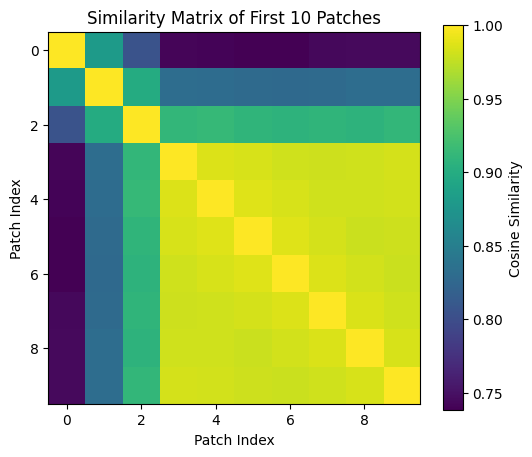

In [ ]:
import matplotlib.pyplot as plt

sim_matrix = cosine_similarity(X_flat[:10])
plt.figure(figsize=(6,5))
plt.imshow(sim_matrix, cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.title("Similarity Matrix of First 10 Patches")
plt.xlabel("Patch Index")
plt.ylabel("Patch Index")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.model_selection import train_test_split

# Convert TensorFlow tensors to NumPy arrays before train-test split
X_patches_np = X_patches.numpy() if isinstance(X_patches, tf.Tensor) else np.array(X_patches)
y_patches_np = y_patches.numpy() if isinstance(y_patches, tf.Tensor) else np.array(y_patches)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_patches_np, y_patches_np, test_size=0.8, stratify=y_patches_np, random_state=42
)

# One-hot encode labels
y_train = keras.utils.to_categorical(y_train, num_classes=17)
y_test = keras.utils.to_categorical(y_test, num_classes=17)

print("Fine-tuning Data Shape:", X_train.shape, y_train.shape)


Fine-tuning Data Shape: (4205, 7, 7, 50, 1) (4205, 17)


In [ ]:
classifier = keras.Sequential([
    encoder,  # Use pretrained SimCLR encoder
    layers.Dense(64, activation='relu'),
    layers.Dense(17, activation='softmax')
])

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = classifier.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=64)


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.4598 - loss: 2.4291 - val_accuracy: 0.3625 - val_loss: 3.2570
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6678 - loss: 1.0409 - val_accuracy: 0.6287 - val_loss: 1.2009
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7434 - loss: 0.7809 - val_accuracy: 0.7672 - val_loss: 0.7061
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7692 - loss: 0.6445 - val_accuracy: 0.7759 - val_loss: 0.6180
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8096 - loss: 0.5426 - val_accuracy: 0.8180 - val_loss: 0.5288
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8295 - loss: 0.4827 - val_accuracy: 0.7993 - val_loss: 0.5713
Epoch 7/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8494 - loss: 0.4347 - val_accuracy: 0.7902 - val_loss: 0.6144
Epoch 8/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8690 - loss: 0.3514 - val_accuracy: 0.8328 - 

In [ ]:
# Access the accuracy and validation accuracy from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Calculate average accuracy over all epochs
avg_train_acc = sum(train_acc) / len(train_acc)
avg_val_acc = sum(val_acc) / len(val_acc)

print(f"Average Training Accuracy: {avg_train_acc:.4f}")
print(f"Average Validation Accuracy: {avg_val_acc:.4f}")

Average Training Accuracy: 0.8855
Average Validation Accuracy: 0.8067


658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


<Figure size 2200x1800 with 0 Axes>

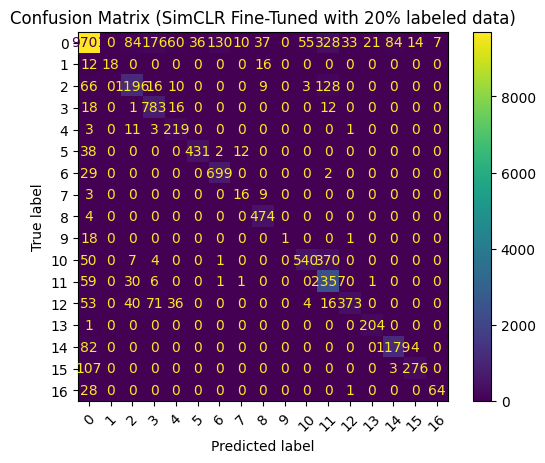

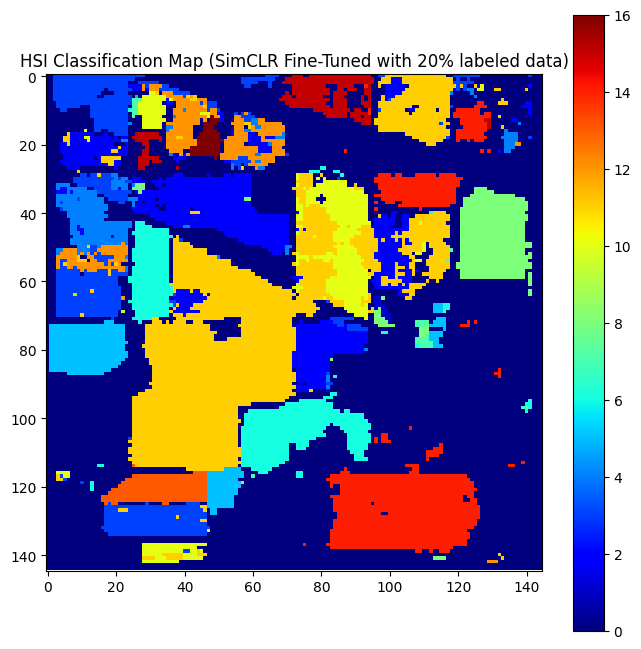

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict on the entire dataset
y_pred = classifier.predict(X_patches)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix using ground truth from y_patches
cm = confusion_matrix(y_patches, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot Confusion Matrix
plt.figure(figsize=(22, 18))
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix (SimCLR Fine-Tuned with 20% labeled data)")
plt.show()

# Reshape predictions to original image dimensions
prediction_map = y_pred_classes.reshape(145, 145)

# Plot Classification Map
plt.figure(figsize=(8, 8))
plt.imshow(prediction_map, cmap='jet')
plt.colorbar()
plt.title("HSI Classification Map (SimCLR Fine-Tuned with 20% labeled data)")
plt.show()


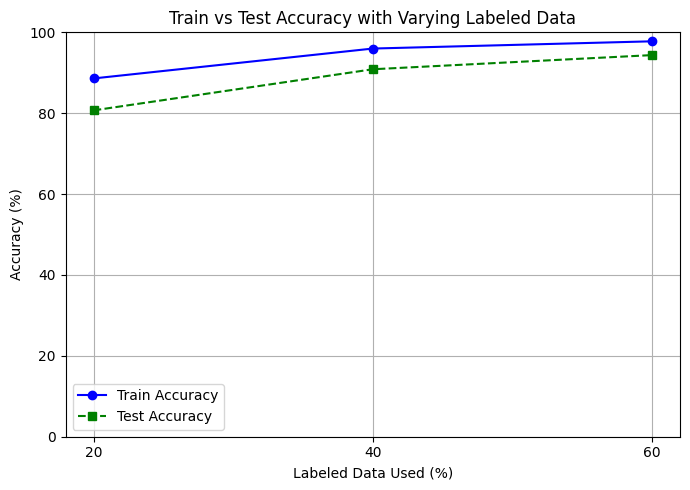

In [ ]:

result = [[88.6, 80.70], [95.99, 90.87], [97.78, 94.37]]
x_label = [20, 40, 60]

import matplotlib.pyplot as plt

# Separate training and testing accuracies
train_acc = [r[0] for r in result]
test_acc = [r[1] for r in result]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(x_label, train_acc, marker='o', linestyle='-', color='blue', label='Train Accuracy')
plt.plot(x_label, test_acc, marker='s', linestyle='--', color='green', label='Test Accuracy')

# Labels and title
plt.title('Train vs Test Accuracy with Varying Labeled Data')
plt.xlabel('Labeled Data Used (%)')
plt.ylabel('Accuracy (%)')
plt.xticks(x_label)
plt.ylim(0, 100)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
